

This notebook contains an example for teaching.


# A Simple Case Study using Wage Data from 2015 - proceeding

So far we considered many machine learning method, e.g Lasso and Random Forests, to build a predictive model. In this lab, we extend our toolbox by predicting wages by a neural network.

## Data preparation

Again, we consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.

In [1]:
# import Pkg; Pkg.add("Flux")

    Updating registry at `C:\Users\sandr\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\sandr\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\sandr\.julia\environments\v1.6\Manifest.toml`


In [2]:
using RData, LinearAlgebra, GLM, DataFrames, Statistics, Random, Distributions, DataStructures, NamedArrays, PrettyTables, Plots
import CodecBzip2

In [3]:
# Importing .Rdata file
rdata_read = load("../data/wage2015_subsample_inference.RData")

Dict{String, Any} with 1 entry:
  "data" => 5150×20 DataFrame…

In [4]:
# Since rdata_read is a dictionary, we check if there is a key called "data", the one we need for our analyze
haskey(rdata_read, "data")

true

In [5]:
# Now we save that dataframe with a new name
data = rdata_read["data"]
names(data)

20-element Vector{String}:
 "wage"
 "lwage"
 "sex"
 "shs"
 "hsg"
 "scl"
 "clg"
 "ad"
 "mw"
 "so"
 "we"
 "ne"
 "exp1"
 "exp2"
 "exp3"
 "exp4"
 "occ"
 "occ2"
 "ind"
 "ind2"

In [6]:
typeof(data), size(data)

(DataFrame, (5150, 20))

In [7]:
Z =  select(data, ["lwage", "wage"])     # regressors

,lwage,wage
,Float64,Float64
1,2.26336,9.61538
2,3.8728,48.0769
3,2.40313,11.0577
4,2.63493,13.9423
5,3.36198,28.8462
6,2.46222,11.7308
7,2.95651,19.2308
8,2.95651,19.2308
9,2.48491,12.0


Firt, we split the data first and normalize it.

In [8]:
Random.seed!(1234) 
training = sample(1:nrow(data), Int(floor(nrow(data)*(3/4))), replace = false)

3862-element Vector{Int64}:
 2455
 3109
 4807
 3107
  617
 2230
 4697
  755
  771
 3729
 2063
  528
 3238
    ⋮
 4057
  973
 4183
 1230
 3228
 3687
 4789
 4060
 2723
 3610
  899
 1273

In [9]:
data_train = data[training,1:16]
data_test = data[Not(training),1:16]
data_train

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,12.0192,2.48651,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,10.2857,2.33076,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,10.5769,2.35867,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,17.3077,2.85115,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,25.641,3.24419,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,42.3077,3.74497,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,15.8654,2.76414,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,72.1154,4.27827,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,35.7143,3.57555,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
size(data_train), size(data_test)

((3862, 16), (1288, 16))

In [11]:
# normalize the data

mean_1 = mean.(eachcol(data_train))
mean_1 = [names(data_train) mean_1]

16×2 Matrix{Any}:
 "wage"   23.3849
 "lwage"   2.97164
 "sex"     0.44407
 "shs"     0.0222683
 "hsg"     0.24754
 "scl"     0.283014
 "clg"     0.310979
 "ad"      0.136199
 "mw"      0.262558
 "so"      0.296737
 "we"      0.215691
 "ne"      0.225013
 "exp1"   13.6699
 "exp2"    2.97307
 "exp3"    8.05316
 "exp4"   24.4216

In [12]:
std_1 = std.(eachcol(data_train))
std_1 = [names(data_train) std_1]

16×2 Matrix{Any}:
 "wage"   20.445
 "lwage"   0.566839
 "sex"     0.496926
 "shs"     0.147574
 "hsg"     0.431639
 "scl"     0.450522
 "clg"     0.462954
 "ad"      0.343044
 "mw"      0.440081
 "so"      0.456879
 "we"      0.411354
 "ne"      0.417645
 "exp1"   10.5105
 "exp2"    3.94797
 "exp3"   14.2448
 "exp4"   52.4952

In [13]:
df = DataFrame()
for i in 1:size(data_train)[2]
     p = (data_train[!, i] .- mean_1[i,2]) / std_1[i,2]
     colname = names(data_train)[i]
     df[!,colname] = p
end
data_train = df
data_train

,wage,lwage,sex,shs,hsg,scl,clg,ad
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.555914,-0.855849,-0.893634,-0.150896,-0.573489,-0.628192,1.48831,-0.39703
2,-0.640703,-1.13062,-0.893634,-0.150896,1.74326,-0.628192,-0.671727,-0.39703
3,-0.62646,-1.08137,-0.893634,-0.150896,-0.573489,1.59146,-0.671727,-0.39703
4,-0.297246,-0.212557,1.11874,-0.150896,-0.573489,1.59146,-0.671727,-0.39703
5,0.110351,0.480836,-0.893634,-0.150896,-0.573489,1.59146,-0.671727,-0.39703
6,0.925545,1.36429,-0.893634,-0.150896,-0.573489,-0.628192,1.48831,-0.39703
7,-0.367792,-0.36606,-0.893634,6.62538,-0.573489,-0.628192,-0.671727,-0.39703
8,2.38349,2.30512,1.11874,-0.150896,-0.573489,-0.628192,1.48831,-0.39703
9,0.603051,1.06541,1.11874,-0.150896,-0.573489,-0.628192,-0.671727,2.51805


In [14]:
df = DataFrame()
for i in 1:size(data_test)[2]
     p = (data_test[!, i] .- mean_1[i,2]) / std_1[i,2]
     colname = names(data_test)[i]
     df[!,colname] = p
end
data_test = df
data_test

,wage,lwage,sex,shs,hsg,scl,clg
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,-0.67349,-1.24951,1.11874,-0.150896,-0.573489,-0.628192,1.48831
2,-0.461853,-0.594011,1.11874,-0.150896,-0.573489,-0.628192,-0.671727
3,-0.555914,-0.855849,1.11874,-0.150896,-0.573489,1.59146,-0.671727
4,-0.498805,-0.692294,-0.893634,-0.150896,1.74326,-0.628192,-0.671727
5,-0.273731,-0.164221,1.11874,-0.150896,-0.573489,-0.628192,-0.671727
6,-0.346322,-0.317912,1.11874,-0.150896,-0.573489,1.59146,-0.671727
7,-0.556854,-0.858674,-0.893634,-0.150896,-0.573489,1.59146,-0.671727
8,-0.181686,0.0131863,-0.893634,-0.150896,-0.573489,-0.628192,1.48831
9,-0.558527,-0.863707,1.11874,-0.150896,1.74326,-0.628192,-0.671727


In [15]:
typeof(data_train), typeof(data_test)

(DataFrame, DataFrame)

Then, we construct the inputs for our network.

In [16]:
formula_basic = @formula(lwage ~ sex + exp1 + shs + hsg+ scl + clg + mw + so + we)
println(formula_basic)

lwage ~ sex + exp1 + shs + hsg + scl + clg + mw + so + we


In [17]:
model_X_basic_train = ModelMatrix(ModelFrame(formula_basic, data_train)).m
model_X_basic_test = ModelMatrix(ModelFrame(formula_basic, data_test)).m

1288×10 Matrix{Float64}:
 1.0   1.11874   -0.634592   -0.150896  …  -0.596613  -0.649488  -0.524344
 1.0   1.11874    1.07799    -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874   -0.777306   -0.150896     -0.596613  -0.649488  -0.524344
 1.0  -0.893634  -0.539448   -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874   -0.254019   -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874    1.03041    -0.150896  …  -0.596613  -0.649488  -0.524344
 1.0  -0.893634  -0.87245    -0.150896     -0.596613  -0.649488  -0.524344
 1.0  -0.893634   1.17313    -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874    0.0314105  -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874    1.64884    -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874   -0.254019   -0.150896  …  -0.596613  -0.649488  -0.524344
 1.0  -0.893634   1.26827    -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874    0.364412   -0.150896     -0.596613  -0.649488  -0.524344


In [255]:
Y_train = data_train[!,"lwage"]
Y_test = data_test[!,"lwage"]

1288-element Vector{Float64}:
 -1.2495116701816313
 -0.5940111369079969
 -0.8558489593188235
 -0.6922940066202594
 -0.16422085652454593
 -0.3179120121732921
 -0.8586738886527183
  0.013186299642166738
 -0.8637071816306149
  0.36697911041067455
  1.3178594848348544
 -1.1634376242266362
 -1.7570311742901377
  ⋮
 -1.2495116701816313
  0.43617103718140365
 -0.07134846692710259
 -0.3847866913343217
 -1.2495116701816313
 -0.8558489593188235
  0.5351222789388115
  0.25782050367552267
 -0.6062199606652643
 -0.4923631674195659
  1.1961444692773646
  0.9241967739720466

In [19]:
# df = DataFrame()
# for i in 1:size(data_train)[2]
#      p = normalize(data_train[!,i])
#      colname = names(data_train)[i]
#      df[!,colname] = p
# end
# df
# # data_test = df
# # data_test


In [20]:
# normalize(data_train[!,])

In [19]:
size(Y_train)

(3862,)

In [20]:
model_X_basic_train

3862×10 Matrix{Float64}:
 1.0  -0.893634   1.07799    -0.150896  …   1.67569   -0.649488  -0.524344
 1.0  -0.893634  -0.444305   -0.150896     -0.596613   1.53928   -0.524344
 1.0  -0.893634   1.12556    -0.150896     -0.596613  -0.649488   1.90665
 1.0   1.11874   -0.920021   -0.150896     -0.596613   1.53928   -0.524344
 1.0  -0.893634   2.17213    -0.150896     -0.596613  -0.649488  -0.524344
 1.0  -0.893634  -0.158876   -0.150896  …   1.67569   -0.649488  -0.524344
 1.0  -0.893634   0.411983    6.62538      -0.596613  -0.649488   1.90665
 1.0   1.11874   -0.444305   -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874   -1.20545    -0.150896     -0.596613  -0.649488  -0.524344
 1.0   1.11874   -0.349162   -0.150896     -0.596613   1.53928   -0.524344
 1.0  -0.893634   0.935271   -0.150896  …   1.67569   -0.649488  -0.524344
 1.0   1.11874    0.507126   -0.150896     -0.596613  -0.649488  -0.524344
 1.0  -0.893634   0.697413   -0.150896     -0.596613   1.53928   -0.524344
 ⋮

### Neural Networks

First, we need to determine the structure of our network. We are using the R package *keras* to build a simple sequential neural network with three dense layers.

In [245]:
size(model_X_basic_train)

(3862, 10)

In [22]:
using Flux
using Flux: crossentropy, @epochs
using Flux.Data: DataLoader
using Flux: throttle
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy

In [440]:
model_nn = Chain(Dense(size(model_X_basic_train,2), 20, relu), 
              Dense(20, size(model_X_basic_train,2), relu),
              Dense(10, 1))

Chain(
  Dense(10, 20, relu),                  # 220 parameters
  Dense(20, 10, relu),                  # 210 parameters
  Dense(10, 1),                         # 11 parameters
)                   # Total: 6 arrays, 441 parameters, 2.098 KiB.

In [441]:
# compile the Flux model
model = model_nn
opt(x, y) = Descent(0.005)
loss(x, y) = Flux.mse(model(x), y)
metrics(x, y) = Flux.mae(model(x), y)

metrics (generic function with 1 method)

In [442]:
ps = Flux.params(model)

Params([Float32[-0.25111067 -0.3757823 … -0.1473076 0.3521537; 0.42798513 0.3700503 … 0.3036116 0.19931784; … ; 0.036239695 -0.30873626 … 0.28635088 -0.19830182; -0.14650546 0.34841874 … 0.39160222 0.24425294], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.13819562 -0.3400847 … 0.37363726 0.14196904; -0.31572184 0.019194778 … -0.27546597 -0.35728145; … ; 0.106541075 0.18728927 … -0.33954594 -0.12612492; 0.16880514 -0.29279855 … 0.31470498 0.23400776], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.10326645 -0.65172416 … -0.0044566807 0.23394632], Float32[0.0]])

Let us have a look at the structure of our network in detail.

In [443]:
model

Chain(
  Dense(10, 20, relu),                  # 220 parameters
  Dense(20, 10, relu),                  # 210 parameters
  Dense(10, 1),                         # 11 parameters
)                   # Total: 6 arrays, 441 parameters, 2.098 KiB.

It is worth to notice that we have in total $441$ trainable parameters.

Now, let us train the network. Note that this takes some computation time. Thus, we are using gpu to speed up. The exact speed-up varies based on a number of factors including model architecture, batch-size, input pipeline complexity, etc.

In [425]:
# m1 = zeros(size(model_X_basic_train, 1), size(model_X_basic_train, 2) - 1 )
# Y_train = hcat(Y_train, m1)

In [445]:
loss(model_X_basic_train', Y_train)

1.2804131600906046

In [446]:
opt(model_X_basic_train', Y_train)

Descent(0.005)

In [447]:
data = DataLoader((model_X_basic_train', Y_train))

DataLoader{Tuple{Adjoint{Float64, Matrix{Float64}}, Vector{Float64}}, Random._GLOBAL_RNG}(([1.0 1.0 … 1.0 1.0; -0.8936342512056518 -0.8936342512056518 … 1.1187362899933146 1.1187362899933146; … ; -0.6494880907521049 1.5392754402117947 … -0.6494880907521049 -0.6494880907521049; -0.5243443952053061 -0.5243443952053061 … -0.5243443952053061 -0.5243443952053061], [-0.8558489593188235, -1.1306215839580365, -1.0813685016534944, -0.21255724980245638, 0.4808359036563729, 1.3642876378055016, -0.36605993603250264, 2.3051157457611646, 1.0654055568474003, -0.4203463113149412  …  0.36697911041067455, -0.7200767539109626, -0.65591812011813, -1.6431743810444392, -0.2622554092553222, 0.6886249651688577, 2.05266181777371, 0.10090219587114307, -0.026683600452133343, -2.0881111049638306]), 1, 3862, true, 3862, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862], false, Random._GLOBAL_RNG())

In [448]:
# training the network 

# @epochs 1000 Flux.train!(loss, ps, data, opt, cb = throttle(() -> println("training"), 10))
@epochs 1000 Flux.train!(loss, ps, data, opt)

┌ Info: Epoch 1
└ @ Main C:\Users\sandr\.julia\packages\Flux\qAdFM\src\optimise\train.jl:143


LoadError: MethodError: no method matching apply!(::typeof(opt), ::Matrix{Float32}, ::Matrix{Float64})
[0mClosest candidates are:
[0m  apply!([91m::ClipNorm[39m, ::Any, ::Any) at C:\Users\sandr\.julia\packages\Flux\qAdFM\src\optimise\optimisers.jl:700
[0m  apply!([91m::ClipValue[39m, ::Any, ::Any) at C:\Users\sandr\.julia\packages\Flux\qAdFM\src\optimise\optimisers.jl:689
[0m  apply!([91m::Nesterov[39m, ::Any, ::Any) at C:\Users\sandr\.julia\packages\Flux\qAdFM\src\optimise\optimisers.jl:104
[0m  ...

After training the neural network, we can evaluate the performance of our model on the test sample.

In [ ]:
# # evaluating the performnace
# model %>% evaluate(model_X_basic_test, Y_test, verbose = 0)

In [462]:
# Calculating the performance measures 

pred_nn = model(model_X_basic_test')'
# We change the type of this variable in order to make numeric operations
pred_nn = vec(pred_nn)

resid_basic = (Y_test .- pred_nn).^2

one = vec(ones(size(Y_test,1),1))

resid_basic = DataFrame([resid_basic], [:resid_basic])

one = DataFrame([one], [:one])
data_aux = [resid_basic one]

fm = @formula(resid_basic ~ 0 + one)

MSE_nn_basic = lm(fm, data_aux, dropcollinear=false)

@show coef(MSE_nn_basic)
@show stderror(MSE_nn_basic)

R2_nn_basic = 1 .- (coef(MSE_nn_basic) / var(Y_test))
println("The R^2 using NN is equal to ", R2_nn_basic) # MSE NN (basic model) 

coef(MSE_nn_basic) = [1.429630112674031]
stderror(MSE_nn_basic) = [0.07172290266319534]
The R^2 using NN is equal to [-0.3603180228906624]


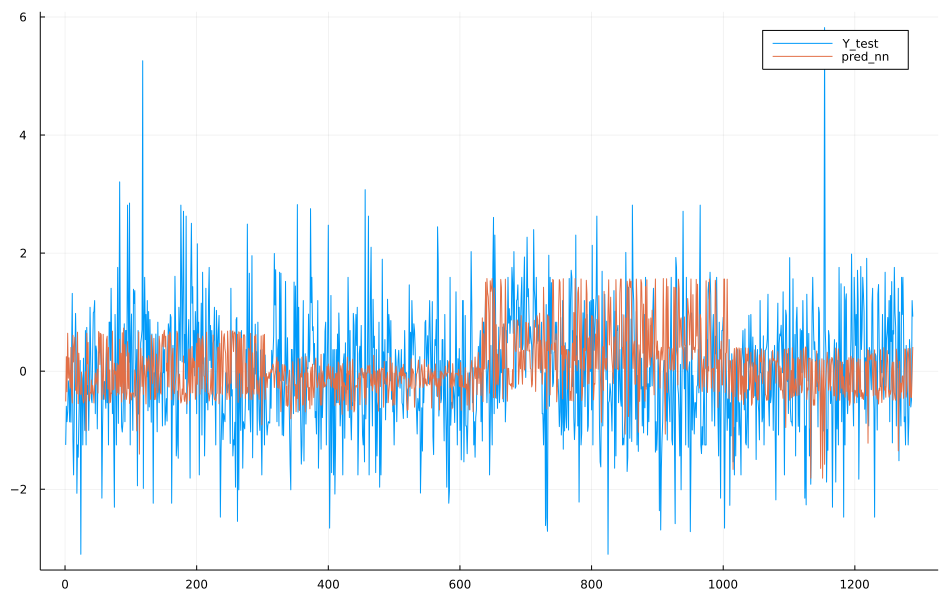

In [463]:
plot(Y_test, label = "Y_test")
plot!(pred_nn, label = "pred_nn")
plot!(size=(950,600))